In [51]:
pip install cvxopt

In [74]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from cvxopt import matrix, solvers
from sklearn.datasets import load_iris

#iris_df = datasets.load_iris()


## getting the data


In [53]:

df_spiral = pd.read_csv("spiral.txt", sep="\t",skiprows = 7)
df_Aggregation = pd.read_csv("Aggregation.txt" , sep="\t",skiprows = 7)
df_Compound = pd.read_csv("Compound.txt" , sep="\t",skiprows = 7)
df_Flame = pd.read_csv("Flame.txt" , sep="\t",skiprows = 7)
df_Jain = pd.read_csv("Jain.txt" , sep="\t",skiprows = 7)
df_Pathbased = pd.read_csv("Pathbased.txt" , sep="\t",skiprows = 7)

#print(df)

In [54]:
def linear_kernel(x, z):
    return np.matmul(x, z.T)

In [55]:
def poly_kernel(x, z, degree, intercept):
        return np.power(np.matmul(x, z.T) + intercept, degree)


In [56]:
def rbf_kernel(X,gamma):
    X_norm = np.sum(X ** 2, axis = -1)
    K = var * np.exp(-gamma * (X_norm[:,None] + X_norm[None,:] - 2 * np.dot(X, X.T)))
    return K

## setting up the data

In [75]:
C = 0.1
m, n = df_spiral.shape
# X = df_spiral.to_numpy()
# y = X[:,2] 
# X = X[:,0:2]
#iris_df = pd.read_csv("IRIS.csv", sep="\t",skiprows = 1)
#X = iris_df.to_numpy()
#X.astype(np.double)
#y = X[:,2] 
#X = X[:,0:2]

iris = load_iris()
iris_df = pd.DataFrame(data= np.c_[iris["data"], iris["target"]], columns= iris["feature_names"] + ["target"])

X = iris_df[["petal length (cm)", "petal width (cm)"]].to_numpy()
y = iris_df[["target"]].to_numpy()

n = n-1;

K = linear_kernel(X, X)
P = matrix(np.matmul(y,y.T) * K)
q = matrix(np.ones((m, 1)) * -1)
A = matrix(y.reshape(1, -1))
b = matrix(np.zeros(1))          
G = matrix(np.vstack((np.eye(m) * -1, np.eye(m))))        
h = matrix(np.hstack((np.zeros(m), np.ones(m) * C)))

In [79]:
import cvxopt
import numpy as np

#from base import BaseModel


class SVMSoftMargin():

    def __init__(self, C: float):
        self.C = C
        self._w = None
        self._b = None

    def train(self, X: np.ndarray, y: np.ndarray):
        n_samples, _ = X.shape
        # compute inputs for cvxopt solver
        K = (X * y[:, np.newaxis]).T
        P = cvxopt.matrix(K.T.dot(K)) # P has shape n*n
        q = cvxopt.matrix(-1 * np.ones(n_samples)) # q has shape n*1
        G = cvxopt.matrix(np.concatenate((-1*np.identity(n_samples), np.identity(n_samples)), axis=0))
        h = cvxopt.matrix(np.concatenate((np.zeros(n_samples), self.C*np.ones(n_samples)), axis=0))
        A = cvxopt.matrix(1.0 * y, (1, n_samples))
        b = cvxopt.matrix(0.0)
        # solve quadratic programming
        cvxopt.solvers.options['show_progress'] = False
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        _lambda = np.ravel(solution['x'])
        # find support vectors
        S = np.where((_lambda > 1e-10) & (_lambda <= self.C))[0]
        self._w = K[:, S].dot(_lambda[S])
        M = np.where((_lambda > 1e-10) & (_lambda < self.C))[0]
        self._b = np.mean(y[M] - X[M, :].dot(self._w))

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Return +1 for positive class and -1 for negative class.
        """
        results = np.sign(X.dot(self._w) + self._b)
        results[results == 0] = 1
        return results

In [80]:
classfier = SVMSoftMargin(C=1e-5)
classfier.train(X,y)

ValueError: shapes (150,150,2) and (2,150,150) not aligned: 2 (dim 2) != 150 (dim 1)

another attempt

In [81]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

In [82]:
clf = SVM()
clf.fit(X, y)

     pcost       dcost       gap    pres   dres
 0: -5.3976e+01 -1.0806e+02  4e+02  2e+01  2e+00
 1: -2.7252e+02 -2.7555e+02  2e+02  9e+00  1e+00
 2: -3.1032e+04 -3.1035e+04  2e+02  9e+00  1e+00
 3: -3.0762e+08 -3.0762e+08  5e+02  9e+00  1e+00
 4: -3.0454e+14 -3.0454e+14  3e+06  9e+00  1e+00
 5: -3.0150e+22 -3.0150e+22  3e+12  9e+05  1e+00
 6: -2.9848e+32 -2.9848e+32  3e+20  8e+15  1e+00
 7: -2.9549e+44 -2.9549e+44  3e+30  9e+27  1e+00
 8: -2.9087e+58 -2.9087e+58  3e+42  6e+41  1e+00
 9: -1.3063e+74 -1.3063e+74  1e+56  3e+57  1e+00
10: -8.6540e+102 -8.6540e+102  9e+84  2e+86  1e+00
11: -8.0612e+138 -8.0612e+138  8e+120 1e+122  6e-01
12: -7.2879e+174 -7.2879e+174  7e+156  5e-02  6e-01
13: -7.2879e+174 -7.2879e+174  7e+156    inf  6e-01
14: -7.2879e+174 -7.2879e+174  7e+156    inf  6e-01
15: -7.2879e+174 -7.2879e+174  7e+156    inf  6e-01
16: -7.2879e+174 -7.2879e+174  7e+156    inf  6e-01
17: -7.2879e+174 -7.2879e+174  7e+156    inf  6e-01
18: -7.2879e+174 -7.2879e+174  7e+156    inf  6

In [87]:
def plot_margin(X1_train, X2_train, clf):
        def f(x, w, b, c=0):
            # given x, return y such that [x,y] in on the line
            # w.x + b = c
            return (-w[0] * x - b + c) / w[1]
        plt.plot(X1_train[:,0], X1_train[:,1], "ro")
        plt.plot(X2_train[:,0], X2_train[:,1], "bo")
        plt.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        # w.x + b = 0
        a0 = -4; a1 = f(a0, clf.w, clf.b)
        b0 = 4; b1 = f(b0, clf.w, clf.b)
        plt.plot([a0,b0], [a1,b1], "k")

        # w.x + b = 1
        a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
        plt.plot([a0,b0], [a1,b1], "k--")

        # w.x + b = -1
        a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
        plt.plot([a0,b0], [a1,b1], "k--")

        plt.axis("tight")
        plt.show()

[1.59506777 0.49165635] [-1.59463621e+177]
[3.24339594e+177] [3.24339594e+177]


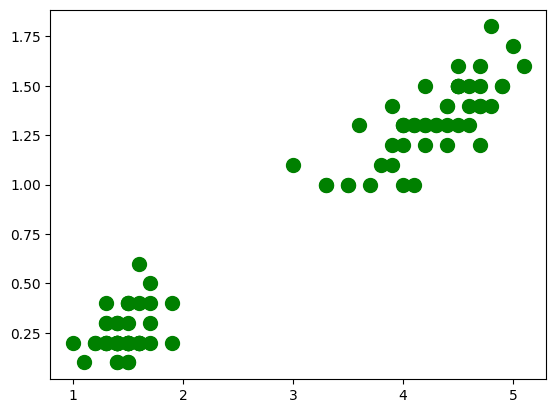

In [99]:
#plot_margin(X,X,clf)
print(clf.w , clf.b)
def f(x, w, b, c=0):
            # given x, return y such that [x,y] in on the line
            # w.x + b = c
            return (-w[0] * x - b + c) / w[1]
plt.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")
a0 = -4; a1 = f(a0, clf.w, clf.b)
b0 = 4; b1 = f(b0, clf.w, clf.b)
#plt.plot([a0,b0], [a1,b1], "k")
 # w.x + b = 1
a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
#plt.plot([a0,b0], [a1,b1], "k--")

# w.x + b = -1
a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
#plt.plot([a0,b0], [a1,b1], "k--")
print(a1 , b1)

In [76]:
solution = solvers.qp(P, q, G, h, A, b)
alphas = np.array(solution['x'])
print(len(alphas))
ind = (alphas > 1e-4).flatten()
sv = X[ind]
sv_y = y[ind]
alphas = alphas[ind]



TypeError: 'P' must be a 'd' matrix of size (311, 311)

In [ ]:
#b = sv_y - np.sum(linear_kernel(sv, sv, degree = 2, intercept = 1) * alphas * sv_y, axis=0)
w = ((y * alphas).T @ X).reshape(-1,1)
S = (alphas > 1e-4).flatten()
b = y[S] - np.dot(X[S], w)
#b = np.sum(b) / b.size
print(w,S,b)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 311 is different from 0)

In [ ]:
prod = np.sum(X * alphas * sv_y, axis=0) + b
predictions = np.sign(prod)

ValueError: operands could not be broadcast together with shapes (311,2) (0,1) 

another attempt

In [ ]:
#print(X)
n = X.shape[0]
K = linear_kernel(X, X)
H = np.matmul(y,y.T) * K
#H = np.matmul(y*X, (y*X).T)
q = np.repeat([-1.0], n)[..., None]
A = y.reshape(1, -1)
b = 0.0
G = np.negative(np.eye(n))
h = np.zeros(n)

P = matrix(H)
q = matrix(q)
G = matrix(G)
h = matrix(h)
A = matrix(A)
b = matrix(b)
sol = solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol["x"])
w = np.dot((y * alphas).T, X)[0]


S = (alphas > 1e-5).flatten()
b = np.mean(y[S] - np.dot(X[S], w.reshape(-1,1)))


print("W:", w)
print("b:", b)

     pcost       dcost       gap    pres   dres
 0: -1.3498e+01 -1.9213e+01  6e+02  2e+01  1e+00
 1: -4.9320e+00 -4.8524e-01  4e+01  2e+00  1e-01
 2: -5.3307e-02 -5.8094e-05  4e-01  2e-02  1e-03
 3: -5.3477e-04 -1.5332e-06  4e-03  2e-04  1e-05
 4: -7.0380e-06 -1.5139e-06  5e-05  2e-06  1e-07
 5: -1.3697e-06 -9.3888e-07  8e-06  3e-07  2e-08
 6: -3.9106e-07 -9.4838e-08  1e-06  5e-08  3e-09
 7: -2.7691e-08 -8.6348e-10  6e-08  2e-09  1e-10
Optimal solution found.
W: [2.55907252e-06 2.01325728e-06]
b: nan


C:\Users\WIN10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\WIN10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


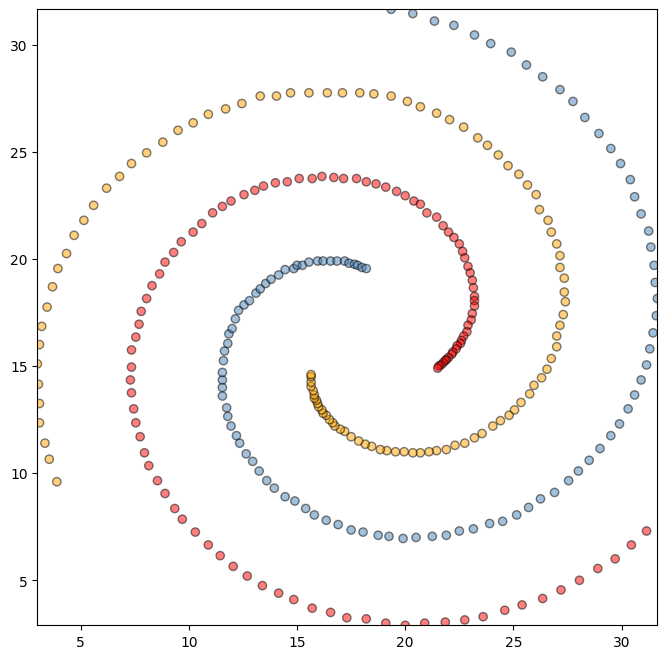

In [ ]:
x_min = np.min(X[:,0])
x_max = np.max(X[:,0])
y_min = np.min(X[:,1])
y_max = np.max(X[:,1])
xx = np.linspace(x_min, x_max)
a = -w[0]/w[1]
yy = a*xx - (b)/w[1]
margin = 1 / np.sqrt(np.sum(w**2))
yy_neg = yy - np.sqrt(1 + a**2) * margin
yy_pos = yy + np.sqrt(1 + a**2) * margin
plt.figure(figsize=(8, 8))
plt.plot(xx, yy, "b-")
plt.plot(xx, yy_neg, "m--")
plt.plot(xx, yy_pos, "m--")
colors = ["steelblue", "orange", "red"]
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, cmap=matplotlib.colors.ListedColormap(colors), edgecolors="black")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

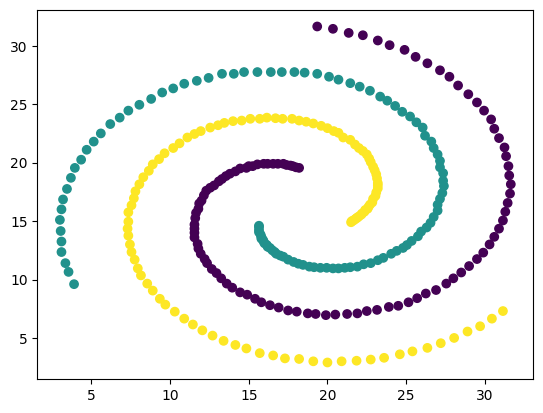

In [ ]:
plt.scatter(X[:,0],X[:,1],c=y)